<h1 style="text-align:center;">Do female patent attorneys engage in more forum shopping?</h1> 
<h2 style="text-align:center;">Evidence from 1999-2015 US cases</h2> 

# Project 1

## 1.1 Introduction

## 1.2 Data Cleaning/Loading

In [637]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from urllib.request import Request, urlopen
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import gc
import seaborn as sns
import sys
import qeds
from sklearn.linear_model import LinearRegression
import math
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# set display settings
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 100

### Cases data

In [35]:
# call cases data to jupyter notebook
cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases.csv")
cases = cases.sort_values("case_name", ascending=True)

### prepare the cases dataset for merging

# create year variable
cases["year_filed"] = cases["case_number"].str.split(":").str[1].str[:2].astype(float)
cases.loc[cases.year_filed > 17, "year_filed"] = cases["year_filed"] + 1900
cases.loc[cases.year_filed < 17, "year_filed"] = cases["year_filed"] + 2000
cases["year_filed"] = cases["year_filed"].fillna(0).astype(float)

# these observations don't have a properly formatted case number
cases = cases.drop(index=[0, 1885, 1886])

# create case order variable (indicates 1 more than the number of cases that the court received before that case in that year)
cases["case_order"] = cases["case_number"].str.split(":").str[1]
cases["case_order"] = cases["case_order"].str.split("-").str[2].astype(float)

# create variable showing the courthouse within the district that received the case
cases["courthouse"] = cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
cases["court_name"] = cases["court_name"].str.title()

# adjust these two specific values
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (Spokane)", "Eastern District Of Washington")
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (7)", "7th Court of Appeals")

# create region variable
for region in ["Eastern", "Southern", "Western", "Northern"]:
    cases.loc[cases.court_name.str.contains(region), "court_region"] = region
cases["court_region"] = cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    cases.loc[cases.court_name.str.contains(state), "court_state"] = state

# process demand variable to get rid of non-numeric values
cases["demand"] = cases["demand"].astype(str)
cases.loc[False == cases.demand.str.strip().str.isalpha(), "demand_num"] = cases["demand"]
cases["demand_num"] = cases["demand_num"].str.replace("$", "")
cases["demand_num"] = cases["demand_num"].str.replace(",", "")
cases["demand_num"] = cases["demand_num"].astype(float)

cases.loc[cases.demand.str.strip().str.isalpha(), "demand_party"] = cases["demand"]
cases["demand_party"] = cases["demand_party"].astype(str)
cases["demand_party"] = cases["demand_party"].str.replace("p", "Plaintiff")
cases.loc[cases.demand_party == "P", "demand_party"] = str("Plaintiff")
cases.loc[cases.demand_party == "y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "Y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "nan", "demand_party"] = np.nan

In [36]:
# call pacer_cases data to jupyter notebook
pacer_cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/pacer_cases.csv")
pacer_cases = pacer_cases.sort_values("case_name", ascending=True)

# prepare the pacer_cases dataset for merging

# construct year variable
pacer_cases["year_filed"] = pacer_cases["case_number"].str.split(":").str[1].str[:4]
pacer_cases.loc[False == pacer_cases["year_filed"].str.isnumeric(), "year_filed"] = pacer_cases["year_filed"].str[:2].astype(float) + 2000
pacer_cases["year_filed"] = pacer_cases["year_filed"].fillna(0).astype(int)
# NOTE: 0 indicates NaN, 56 values

# construct case order (-1 indicates the number of cases that the court received before that case in that year)
pacer_cases["case_order"] = pacer_cases["case_number"].str.split(":").str[1]
pacer_cases["case_order"] = pacer_cases["case_order"].str.split("-").str[2]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str.split(".").str[0]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str[:5]
pacer_cases["case_order"] = pacer_cases["case_order"].astype(float)

# indicates the courthouse within the district that received the case
pacer_cases["courthouse"] = pacer_cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
pacer_cases["court_name"] = pacer_cases["court_name"].str.title()
pacer_cases["court_name"] = pacer_cases["court_name"].str.split("(").str[0]

# create region variable
for region in ["Eastern", "Southern", "Western", "Northern"]:
    pacer_cases.loc[pacer_cases.court_name.str.contains(region), "court_region"] = region
pacer_cases["court_region"] = pacer_cases["court_region"].fillna("None")

# create state variable
for state in state_names:
    pacer_cases.loc[pacer_cases.court_name.str.contains(state), "court_state"] = state

In [37]:
# merge
m_cases = pd.merge(cases, pacer_cases, on=["year_filed", "case_order", "courthouse", "court_region", "court_state"], how="left")

# fill in missing values from the cases dataset using the pacer_cases dataset
m_cases["case_name_x"] = m_cases["case_name_x"].fillna(m_cases["case_name_y"])
m_cases["date_filed_x"] = m_cases["date_filed_x"].fillna(m_cases["date_filed_y"])
m_cases["date_closed_x"] = m_cases["date_closed_x"].fillna(m_cases["date_filed_y"])

# check for missing values
m_cases.isna().sum()

# group dataset by whether the year is before or after 1999
m_cases.loc[m_cases.year_filed >= 1999, "post_99"] = 1
m_cases.loc[m_cases.year_filed < 1999, "post_99"] = 0
grouped_cases = m_cases.groupby(by="post_99")

# convert dates to date format
m_cases["date_filed"] = pd.to_datetime(m_cases["date_filed_x"])
m_cases["date_closed"] = pd.to_datetime(m_cases["date_closed_x"])
m_cases["date_last_filed"] = pd.to_datetime(m_cases["date_last_filed"])

# drop superfluous variables
m_cases = m_cases.drop(columns=["date_filed_x", "date_closed_x", "case_name_y", "court_name_y", "date_closed_y", "case_number_y", 
                                "pacer_id_y", "date_filed_y"])

# make a subset of the dataset with just the cases since 1999
cases_99 = m_cases.drop(m_cases[m_cases["post_99"] != 1].index)

# create a binary variable indicating whether a case involves patent infringement
cases_99["case_cause"] = cases_99["case_cause"].str.lower()
cases_99["case_cause"] = cases_99["case_cause"].str.strip()
cases_99.loc[cases_99.case_cause.str.contains("infringement of patent", na=False), "patent_infringement"] = 1
cases_99.loc[cases_99.case_cause.str.contains("patent infringement", na=False), "patent_infringement"] = 1
cases_99["patent_infringement"] = cases_99["patent_infringement"].fillna(0)

# delete superfluous datasets
del [m_cases, cases, pacer_cases]
gc.collect()
m_cases = pd.DataFrame()
cases = pd.DataFrame()
pacer_cases = pd.DataFrame()

### Attorneys Data

In [39]:
# call data to jupyter notebook
attorneys = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys.csv")
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender_nocode.csv")

# fill (See above for address) using above
attorneys["contactinfo"] = attorneys["contactinfo"].fillna(0)
attorneys["contactinfo"] = attorneys["contactinfo"].str.strip()
attorneys["contactinfo"] = attorneys["contactinfo"].replace('(See above for address)', np.nan)
attorneys["contactinfo"] = attorneys["contactinfo"].ffill()

# extract zip code
attorneys["zip"] = attorneys["contactinfo"].str.extract(r"(, [a-zA-Z][a-zA-Z] \d\d\d\d\d)")
attorneys["zip"] = attorneys["zip"].str[5:]

# collapse dataset so that there's only one entry per attorney per case
attorneys = attorneys.groupby(["case_row_id", "name"]).agg("first")
attorneys = attorneys.reset_index()

# extract firm name
attorneys["firm"] = attorneys["contactinfo"].str.split(";").str[0]

# create variable w first name
attorneys["first_name"] = attorneys["name"].str.split().str[0].str.lower().astype(str)

# merge with gender dataset, drop the dataset
attorneys = attorneys.merge(gender, left_on="first_name", right_on="name", how="left")
del [gender]
gc.collect()
gender = pd.DataFrame()

In [40]:
# create dataset with the attorneys whose gender is missing
missing_attorneys = attorneys[attorneys["gender"].isna()]
missing_attorneys = missing_attorneys[missing_attorneys["name_x"].isna() == False]

# merge with dataset with gender names for US
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender-code_US_likely.csv")
missing_attorneys = missing_attorneys.merge(gender, left_on="first_name", right_on="name",how="left")

# drop variables so you can concat the missing_attorneys dataset with the attorneys dataset
missing_attorneys = missing_attorneys.drop(["name_y", "gender_x"], axis= 1)
missing_attorneys = missing_attorneys.rename(columns={"gender_y": "gender"})

still_missing = missing_attorneys[missing_attorneys["gender"].isna()== True]
still_missing.to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/still_missing_attorneys.csv", index=False)
# processed these names using https://genderize.io/tools/csv

missing_attorneys = missing_attorneys[missing_attorneys["gender"].isna()== False]

# drop missing values from the attorneys dataset, add back the missing_attorneys
attorneys = attorneys[attorneys["gender"].isna() == False]
attorneys = attorneys.rename(columns={"name_y": "name"})
attorneys = pd.concat([attorneys, missing_attorneys], axis = 0)

del [missing_attorneys]
gc.collect()
missing_attorneys = pd.DataFrame()

# add back the still_missing_attorneys
still_missing = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/still_missing_attorneys_genderized_copy.csv")

# ready the dataset for concating
still_missing.loc[still_missing.gender == "male", "gender"] = "M"
still_missing.loc[still_missing.gender == "female", "gender"] = "F"
still_missing.replace("unknown", np.nan)

attorneys = pd.concat([attorneys, still_missing], axis=0)
attorneys.drop(columns=["name"], inplace=True)

del [still_missing]
gc.collect()
still_missing = pd.DataFrame()

In [41]:
# label each attorney either defendent, plantiff, or other
list(attorneys["party_type"].unique())
attorneys["party_type"] = attorneys["party_type"].str.lower()

attorneys.loc[attorneys.party_type.str.contains("defendant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("respondent"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("counter claimant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("dft"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("plaintiff"), "plaintiff"] = 1

attorneys.loc[attorneys.defendant.isna(), "other"] = 1
attorneys.loc[attorneys.plaintiff.isna() == False, "other"] = 0

# create gendered variables for each attorney category
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "M"), "defendant_M"] = 1
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "F"), "defendant_F"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "M"), "plaintiff_M"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "F"), "plaintiff_F"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "M"), "other_M"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "F"), "other_F"] = 1

attorneys.loc[attorneys["gender"] == "M", "male"] = 1
attorneys.loc[attorneys["gender"] == "F", "female"] = 1
attorneys["total"] = 1

attorneys[['defendant', 'plaintiff', 'other', 'defendant_M', 'defendant_F', 'plaintiff_M', 'plaintiff_F','other_M',  'other_F', 'male', 
           'female']] = attorneys[['defendant', 'plaintiff', 'other', 'defendant_M', 'defendant_F', 'plaintiff_M', 'plaintiff_F','other_M', 
                                   'other_F', 'male', 'female']].fillna(value=0)

In [42]:
# delete unnecessary columns, then aggregate
c_attorneys = attorneys.drop(columns=["name_x", "case_number", 'party_row_count', 'party_type', 'attorney_row_count', 'contactinfo', 'position', 'zip', 
                                      'firm', 'first_name', "gender"])

# aggregate to create one row per case
c_attorneys = c_attorneys.groupby("case_row_id").agg({'defendant': "sum",
 'plaintiff': "sum",
 'other': "sum",
 'defendant_M': "sum",
 'defendant_F': "sum",
 'plaintiff_M': "sum",
 'plaintiff_F': "sum",
 'other_M': "sum",
 'other_F': "sum",
 'male': "sum",
 'female': "sum",
 'total': "sum"})

c_attorneys = c_attorneys.fillna(0)

### Documents data

In [44]:
# call data to jupyter notebook
documents = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/documents.csv", low_memory=False)

# aggregate to count the number of documents
documents["number_docs"] = 1
doc_agg = documents.groupby("case_row_id").agg("sum")

# drop unnecessary columns
doc_agg = doc_agg.drop(doc_agg.iloc[:, 0:8], axis=1)

del [documents]
gc.collect()
documents = pd.DataFrame()

### Names data

In [46]:
# call data to jupyter notebook
names = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/names.csv")

### Merging

In [48]:
# merge to create dataframe with one row per case
df_cases = cases_99.merge(c_attorneys, on="case_row_id", how="left")
df_cases = df_cases.merge(doc_agg, on="case_row_id", how="left")

df_cases.drop(columns=["pacer_id_x", "assigned_to", "referred_to", "case_cause", "jurisdictional_basis", "jury_demand", "lead_case", "related_case", 
                       "settlement", "date_last_filed", "demand_num", "demand", "demand_party", "court_code", "post_99", "date_filed", "date_closed"], inplace=True) 

df_cases.sort_values(by=["case_row_id"], inplace=True)

df_cases = df_cases.rename(columns={"case_number_x": "case_number",
                                "case_name_x": "case_name",
                                "court_name_x": "court_name"
                               })

In [49]:
# merge to create df with one row per attorney
df_att = attorneys.merge(df_cases, on="case_row_id", how="inner")

In [50]:
# create inhouse attorney dataset

df_att.drop(columns=["total_x", "case_number_y", "party_row_count"], inplace=True) 

# rename columns to ready for merging
df_att = df_att.rename(columns={"case_number_x": "case_number",
                        "name_x": "name_attorney",
                        "defendant_x": "defendant",
                        "plaintiff_x": "plaintiff",
                        "other_x": "other",
                        "defendant_M_x": "defendant_M",
                        "defendant_F_x": "defendant_F",
                        "plaintiff_M_x": "plaintiff_M",	
                        "plaintiff_F_x": "plaintiff_F",
                        "other_M_x": "other_M",
                        "other_F_x": "other_F",
                        "male_x": "male",	
                        "female_x": "female",		
                        "defendant_y": "tot_def",
                        "plaintiff_y": "tot_plain",
                        "witness_y": "tot_wit",
                        "other_y": "tot_other",
                        "defendant_M_y": "tot_def_M",
                        "defendant_F_y": "tot_def_F",
                        "plaintiff_M_y": "tot_plain_M",
                        "plaintiff_F_y": "tot_plain_F",
                        "other_M_y": "tot_other_M",
                        "other_F_y": "tot_other_F",
                        "male_y": "tot_M",
                        "female_y": "tot_F",
                        "total_y": "tot"
                               })

df_att["firm"] = df_att["firm"].str.title()
names["name"] = names["name"].str.title()

for extra in ["Llc", " L.L.C.", " Co ", "Company", "Corporation", "Co.", "Inc.", "Incorporated", "Corp."]:
    df_att["firm"] = df_att["firm"].str.replace(extra, "")
    names["name"] = names["name"].str.replace(extra, "")
    
df_att["firm"] = df_att["firm"].str.strip(",. ")
names["name"] = names["name"].str.strip(",. ")

# merge name and df on party/firm to create a dataset of inhouse attorneys
df_inhouse = df_att.merge(names, left_on=["firm", "case_row_id"], right_on=["name","case_row_id"], how="inner")

# collapse dataset by attorney, party_row_count
df_inhouse = df_inhouse.groupby(["name_attorney", "party_row_count", "case_row_id"]).agg("first")
df_inhouse.reset_index(inplace=True)

In [51]:
# save the datasets as csv
df_inhouse.to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/inhouse_attorneys.csv",index = False)
df_att.to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv",index = False)
df_cases.to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases_merged.csv",index = False)

In [52]:
# detete the df
del [df_inhouse, df_cases, df_att]
gc.collect()
df_inhouse = pd.DataFrame()
df_cases = pd.DataFrame()
df_att = pd.DataFrame()

## 1.3 Summary Statistics Tables

### Table 1

In [308]:
df = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases_merged.csv")
df["total_cases"] = 1

In [94]:
# summary statistics for X variables and Y variable

df_summaries = df.drop(['case_number', 'case_name', 'court_name', 'courthouse'], axis=1)
df_summaries = df_summaries.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_summaries = df_summaries.reset_index()

# create variable showing proportion of case filings made in year in a given court
for year in range(1999, 2016):
    df_summaries.loc[df_summaries["year_filed"] == year, "total_filings"] = df_summaries[df_summaries["year_filed"] == year]["total_cases"].sum(axis=0)

df_summaries["percent_filings"] = 100* df_summaries["total_cases"] / df_summaries["total_filings"] 

# create percent female variables
df_summaries["percent_female"] = 100 * df_summaries["female"] / (df_summaries["female"] + df_summaries["male"])
df_summaries["percent_female_P"] = 100 * df_summaries["plaintiff_F"] / (df_summaries["plaintiff_F"] + df_summaries["plaintiff_M"])
df_summaries["percent_female_D"] = 100 * df_summaries["defendant_F"] / (df_summaries["defendant_F"] + df_summaries["defendant_F"])
df_summaries.loc[df_summaries["percent_female_P"].isna(), "percent_female_P"] = 0
df_summaries.loc[df_summaries["percent_female_D"].isna(), "percent_female_D"] = 0
df_summaries.loc[df_summaries["percent_female"].isna(), "percent_female"] = 0

df_summaries["average_docs"] = df_summaries["total_filings"] / df_summaries["total_cases"]

df_summaries = df_summaries[["year_filed", "total_cases", "patent_infringement", "percent_filings", "average_docs", "percent_female_P", "plaintiff", 
                             "percent_female_D", "defendant", "percent_female", "female", "male", "total"]]

df_summaries["year_filed"] = df_summaries["year_filed"].astype(int)

# rename to make the rows clear
df_summaries = df_summaries.rename(columns={"year_filed": "Year filed", "total_cases": "Cases filed", "patent_infringement": "Patent infringement cases", 
                                            "percent_filings":"Percent of all annual filings filed in a district court", 
                                            "average_docs": "Average documents per case", "percent_female_P": "Percent of plaintiff lawyers who are women", 
                                            "plaintiff": "Plaintiff lawyers", "percent_female_D": "Percent of defense lawyers who are women", 
                                            "defendant": "Defendant lawyers", "percent_female": "Percent all lawyers who are women", 
                                            "female": "Female lawyers", "male": "Male lawyers", "total": "Total lawyers"})

np.round(df_summaries.describe()).T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Year filed,2007.0,5.0,1999.0,2015.0
Cases filed,40.0,125.0,1.0,2564.0
Patent infringement cases,34.0,120.0,0.0,2552.0
Percent of all annual filings filed in a district court,2.0,4.0,0.0,58.0
Average documents per case,543.0,822.0,2.0,4440.0
Percent of plaintiff lawyers who are women,14.0,11.0,0.0,100.0
Plaintiff lawyers,133.0,422.0,0.0,6631.0
Percent of defense lawyers who are women,42.0,19.0,0.0,50.0
Defendant lawyers,163.0,597.0,0.0,7445.0
Percent all lawyers who are women,15.0,9.0,0.0,100.0


### Table 2

In [239]:
# summary statistics for women and men attorneys

# crop the datasets for merging
df_small = df.drop(['case_number', 'case_name', 'court_name', 'courthouse'], axis=1)

sum_attorneys = attorneys[["name_x", "case_row_id", "gender", "defendant", "plaintiff", "other"]]

sum_attorneys = sum_attorneys.groupby("name_x").agg({"case_row_id": "first", "gender": "first", "defendant": "sum", "plaintiff": "sum", "other": "sum"})
sum_attorneys = sum_attorneys.reset_index()

totals = list(sum_attorneys.groupby('gender')['name_x'].nunique())

# merge datasets
sum_attorneys = sum_attorneys.merge(df_small, on="case_row_id", how="left")

sum_attorneys = sum_attorneys.rename(columns={"plaintiff_x": "Plaintiff attorney listings", "defendant_x": "Defendant attorney listings", "other_x": "Other attorneys",
                                              "patent_infringement": "Proportion patent infringement cases", "female": "Average women attorneys on cases",
                                              "total": "Average number of attorneys on cases", "number_docs": "Average documents per case", 
                                              "year_filed": "Most commonly filed in year"})


stats = sum_attorneys.groupby(["gender"]).agg({"Plaintiff attorney listings": "sum", "Defendant attorney listings": "sum", "Other attorneys": "sum", 
                                               "Proportion patent infringement cases": "mean", "Average women attorneys on cases": "mean", 
                                              "Average number of attorneys on cases": "mean", "Average documents per case": "mean", 
                                               "Most commonly filed in year": lambda x: x.value_counts().index[0]})

stats = stats.round({"Most commonly filed in year":0})
stats = stats.transpose()
stats = stats[["F", "M"]]
stats = stats.rename(columns={"F":"Women", "M": "Men"})

stats.loc[len(stats)] = [totals[1], totals[2]] 
stats.rename(index={8: "Total unique attorneys"},inplace=True)

# round rows
stats.Women = [round(x,y) for x , y in zip(stats.Women,[0, 0, 0, 2, 2, 2, 2, 2, 0])]
stats.Men = [round(x,y) for x , y in zip(stats.Women,[0, 0, 0, 2, 2, 2, 2, 2, 0])]

stats

gender,Women,Men
Plaintiff attorney listings,34203.00,34203.00
Defendant attorney listings,47655.00,47655.00
Other attorneys,1451.00,1451.00
Proportion patent infringement cases,0.87,0.87
Average women attorneys on cases,4.76,4.76
Average number of attorneys on cases,19.85,19.85
Average documents per case,231.47,231.47
Most commonly filed in year,2011.00,2011.00
Total unique attorneys,23003.00,23003.00


## 1.4 Plots, Histograms, Figures

### Figure 1: Distribution of documents filed per US patent case by attorney gender, 1999-2015

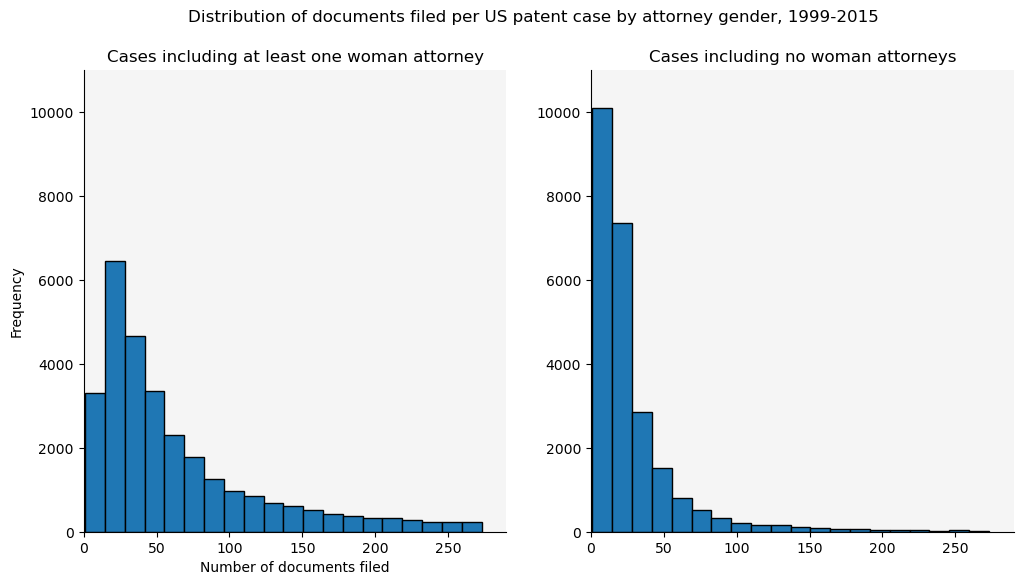

In [241]:
# histogram of the number of documents filed per case
df_hist = df[df["number_docs"] < df["number_docs"].quantile(0.95)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df_hist[df_hist["female"] >= 1].plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, ax=ax[0], edgecolor = "black"
)

df_hist[df_hist["female"] == 0].plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, ax=ax[1], edgecolor = "black"
)

ax[0].set_title("Cases including at least one woman attorney")
ax[1].set_title("Cases including no woman attorneys")

ax[1].set_ylabel("")
ax[0].set_xlabel("Number of documents filed")

ax[0].set_facecolor((0.96, 0.96, 0.96))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].set_facecolor((0.96, 0.96, 0.96))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[0].set_ylim((0, 11000))
ax[0].set_xlim((0, 290))

ax[1].set_ylim((0, 11000))
ax[1].set_xlim((0, 290))

fig.suptitle("Distribution of documents filed per US patent case by attorney gender, 1999-2015")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/histogram_doc_filings.png", dpi=300, format="png")

### Figure 2: Gender make-up of patent attorneys litigating in US district courts, 1999-2015

In [275]:
### bar chart of % of lawyers who are women by party type

# collapse dataset over year ranges
df_year = df.drop(['case_row_id','courthouse', "case_number", "case_name", "court_name"], axis=1)
df_year.loc[df_year["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_year.loc[(2006 <= df_year["year_filed"]) & (df_year["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_year.loc[df_year["year_filed"] >= 2011, "year_range"] = "2011-2015"

df_year = df_year[['year_range', 'defendant', 'plaintiff', 'other', 'defendant_M', 'defendant_F', 'plaintiff_M', 'plaintiff_F', 'other_M', 'other_F', 'male', 
                   'female', 'total', "total_cases"]]
df_year = df_year.groupby("year_range").agg("sum")
df_year = df_year.reset_index()

# create variables with proportion of female attorneys for each party type
df_year["percent_f"] = 100 * df_year["female"] / df_year["total"]
df_year["percent_m"] = 100 * df_year["male"] / df_year["total"]
df_year["percent_unknown"] = 100 * (df_year["total"] - df_year["female"] - df_year["male"])/ df_year["total"]

df_year["percent_pl_f"] = 100 * df_year["plaintiff_F"] / df_year["plaintiff"]
df_year["percent_pl_m"] = 100 * df_year["plaintiff_M"] / df_year["plaintiff"]
df_year["percent_pl_unknown"] = 100 * (df_year["plaintiff"] - df_year["plaintiff_M"] - df_year["plaintiff_F"])/ df_year["plaintiff"]

df_year["percent_def_f"] = 100 * df_year["defendant_F"] / df_year["defendant"]
df_year["percent_def_m"] = 100 * df_year["defendant_M"] / df_year["defendant"]
df_year["percent_def_unknown"] = 100 * (df_year["defendant"] - df_year["defendant_M"] - df_year["defendant_F"])/ df_year["defendant"]

df_year = df_year.drop(df_year.iloc[:, 1:12], axis=1)

In [277]:
Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    
    # append the list to the final list
    Row_list.append(my_list)

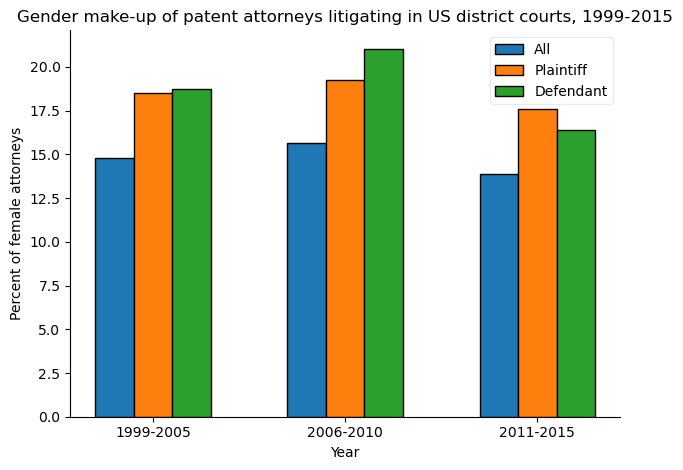

In [279]:
labels = ["All", "Plaintiff", "Defendant"]

Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    # append the list to the final list
    Row_list.append(my_list)

range_1 = Row_list[0]
range_2 = Row_list[1]
range_3 = Row_list[2]

fig, ax = plt.subplots()

index = np.arange(3)
width = 0.2

rects1 = ax.bar(
    index, range_1, width, label='All', edgecolor="black"
)

rects2 = ax.bar(
    index + width, range_2, width, label='Plaintiff', edgecolor="black"
)

rects3 = ax.bar(
    index + width*2, range_3, width, label='Defendant', edgecolor="black"
)

ax.set_xlabel('Year')
ax.set_ylabel('Percent of female attorneys')
ax.set_title('Gender make-up of patent attorneys litigating in US district courts, 1999-2015')
ax.set_xticks(index + width )
ax.set_xticklabels(('1999-2005', '2006-2010', '2011-2015'))
ax.legend(framealpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/bar_attorney_gender.png", dpi=300, format="png")

### Figure 3: US federal courts' patent filings and the gender make-up of attorneys 

In [360]:
### relationship between the proportion of court filings and the proportion of lawyers in a court who a women

df_court = df.drop(['courthouse', "case_number", "case_name"], axis=1)

# create variables indicating year ranges
df_court.loc[df_court["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_court.loc[(2006 <= df_court["year_filed"]) & (df_court["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_court.loc[df_court["year_filed"] >= 2011, "year_range"] = "2011-2015"

# group the dataset by court district and year range
df_court = df_court[["court_state", "court_region", "year_range", "total_cases", "plaintiff", "plaintiff_F","plaintiff_M"]]
df_court["court_region"] = df_court["court_region"].fillna("None")

In [362]:
df_court = df_court.groupby(["court_state", "court_region", "year_range"]).agg("sum")
df_court = df_court.reset_index()

# create variable showing proportion of case filings made in year range in a given court
df_court.loc[df_court["year_range"] == "1999-2005", "total_filings"] = df_court[df_court["year_range"] == "1999-2005"]["total_cases"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2006-2010", "total_filings"] = df_court[df_court["year_range"] == "2006-2010"]["total_cases"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2011-2015", "total_filings"] = df_court[df_court["year_range"] == "2011-2015"]["total_cases"].sum(axis=0)
df_court["percent_filings"] = 100 * df_court["total_cases"] / df_court["total_filings"] 

df_court["percent_female"] = 100 * df_court["plaintiff_F"] / (df_court["plaintiff_F"] + df_court["plaintiff_M"])
df_court.sort_values(by=["percent_filings"])
df_court.loc[df_court["percent_female"].isna(), "percent_female"] = 0

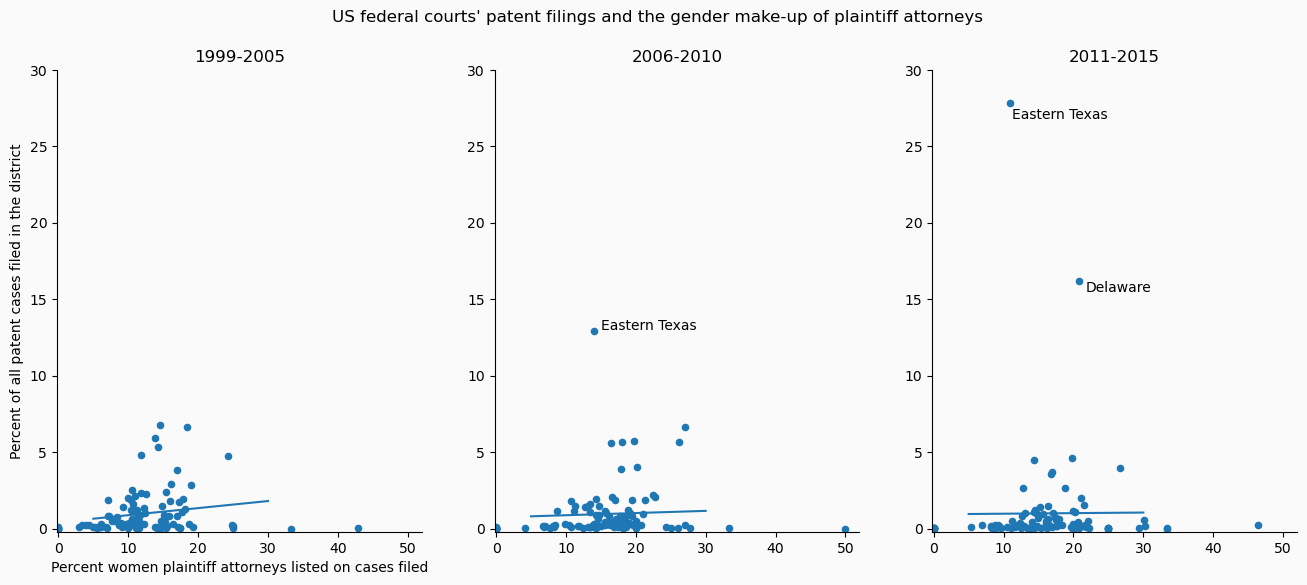

In [380]:
def single_scatter_plot(df, year, ax):
    """
    This function creates a single year's percent filings to percent female plot
    """
    # Filter data to keep only the data of interest
    _df = df_court[df_court['year_range'] == year]
    _df.plot(
        kind="scatter", x="percent_female", y="percent_filings", ax=ax
    )

    lr = LinearRegression()
    X = _df["percent_female"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
    y = _df["percent_filings"].values.reshape(-1, 1) # the output is an array
    lr.fit(X, y)

    x = np.linspace(5.0, 30.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred)

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for (i, year) in enumerate(df_court.year_range.unique()):
    single_scatter_plot(df, year, ax[i])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Percent women plaintiff attorneys listed on cases filed")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((-0.2, 30))
    _ax.set_xlim((-0.2, 52))
 
    # Change ticks
    # xticks = [10, 100, 1000, 10000]
    # _ax.set_xticks([np.log(xi) for xi in xticks])
    # _ax.set_xticklabels([str(xi) for xi in xticks])

    # yticks = list(range(5, 32, 5))
    # _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        # _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Percent of all patent cases filed in the district")
    else:
        # _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].set_zorder(1)
ax[2].annotate("Eastern Texas", (11.2, 26.8), color="black")
ax[2].annotate("Delaware", (21.7, 15.5), color="black")
ax[1].annotate("Eastern Texas", (15, 13), color="black")
fig.suptitle("US federal courts' patent filings and the gender make-up of plaintiff attorneys")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/scatter_filings_gender.png", dpi=300, format="png")

### Figure 4: Patent cases filed in most filed in US district circuits, 1999-2015

In [388]:
# percent filings in top 10 courts by year

df_top = df[["court_state", "court_region", "year_filed", "total_cases"]]
df_top = df_top.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_top = df_top.reset_index()

# create variable showing proportion of case filings made in year range in a given court
for year in range(1999, 2016):
    df_top.loc[df_top["year_filed"] == year, "total_filings"] = df_top[df_top["year_filed"] == year]["total_cases"].sum(axis=0)

# create new dataset with top 10 courts, bottom 10 courts
df_top_years = df_top[df_top["year_filed"] == 1999].nlargest(10, "total_cases")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nlargest(10, "total_cases")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years["top10"] = 1

df_bottom_years = df_top[df_top["year_filed"] == 1999].nsmallest(50, "total_cases")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nsmallest(50, "total_cases")
    df_bottom_years = pd.concat([df_bottom_years, _df], axis = 0)
df_bottom_years["top10"] = 0

df_top_years["year_filed"] = df_top_years["year_filed"].astype(int)
df_top_years = df_top_years.groupby(["top10", "year_filed"]).agg({"total_cases":"sum", "total_filings": "max"})

df_top_years["percent_filings"] = 100* df_top_years["total_cases"] / df_top_years["total_filings"]

df_bottom_years["year_filed"] = df_bottom_years["year_filed"].astype(int)
df_bottom_years = df_bottom_years.groupby(["top10", "year_filed"]).agg({"total_cases":"sum", "total_filings": "max"})

df_bottom_years["percent_filings"] = 100* df_bottom_years["total_cases"] / df_bottom_years["total_filings"]

# df_top_years = df_top_years.reset_index()
# df_bottom_years = df_bottom_years.reset_index()

df_topbot = pd.concat([df_top_years, df_bottom_years], axis=0)
df_topbot = df_topbot.reset_index()

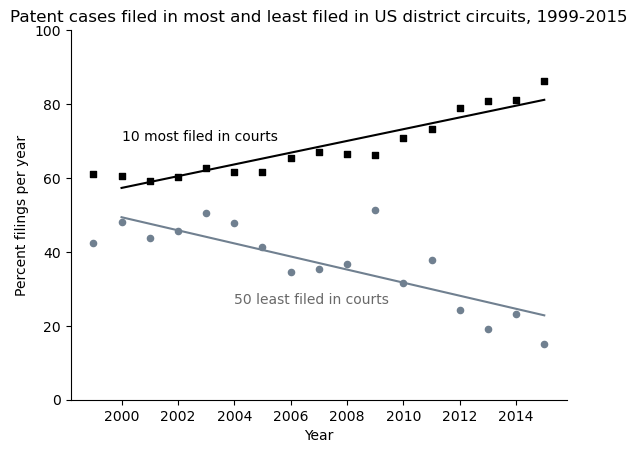

In [402]:
fig, ax = plt.subplots()

_df = df_topbot[df_topbot['top10'] == 1]
_df.plot(kind="scatter", x="year_filed", y="percent_filings", marker="s", c="black", ax=ax)

lr = LinearRegression()
X = _df["year_filed"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
y = _df["percent_filings"].values.reshape(-1, 1) # the output is an array
lr.fit(X, y)

x = np.linspace(2000, 2015).reshape(-1, 1)
y_pred = lr.predict(x)
ax.plot(x, y_pred, color="black")

_df = df_topbot[df_topbot['top10'] == 0]
_df.plot(kind="scatter", x="year_filed", y="percent_filings", marker="o", c="slategray", ax=ax)

lr = LinearRegression()
X = _df["year_filed"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
y = _df["percent_filings"].values.reshape(-1, 1) # the output is an array
lr.fit(X, y)

x = np.linspace(2000, 2015).reshape(-1, 1)
y_pred = lr.predict(x)
ax.plot(x, y_pred, color="slategray")

ax.set_ylim((0,100))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Year")
ax.set_ylabel("Percent filings per year")
ax.set_title("Patent cases filed in most and least filed in US district circuits, 1999-2015")

ax.annotate("10 most filed in courts", (2000, 70), color="black")
ax.annotate("50 least filed in courts", (2004, 26), color="dimgray")

plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/scatter_top10.png", dpi=200, format="png", bbox_inches="tight")

# Project 2

## 2.1 The Message

In [404]:
# import the inhouse attorneys dataset
df_inhouse = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/inhouse_attorneys.csv")

# drop rows without zip codes
print(len(df_inhouse.index))
df_inhouse.dropna(subset=["zip"], how="all", inplace=True)
print(len(df_inhouse.index))

# import court district and zip code shape files
district_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/U.S._District_Courts.zip")
zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2020_us_zcta510.zip")

1889
1878


In [406]:
# merge the inhouse attorney dataset with the zip code file
zip_df["ZCTA5CE10"] = zip_df["ZCTA5CE10"].astype(float)
inhouse_zip = df_inhouse.merge(zip_df, how="left", left_on="zip", right_on="ZCTA5CE10")
inhouse_zip[inhouse_zip.isna().any(axis=1)]

# inhouse_zip[["zip","ZCTA5CE20"]].head(20)
inhouse_zip.head()

inhouse_zip[inhouse_zip["ZCTA5CE10"].isna()]
inhouse_zip.drop(columns=["CLASSFP10", "MTFCC10", "FUNCSTAT10",	"ALAND10",	"AWATER10",	"INTPTLAT10", "INTPTLON10"], inplace=True)

# merge zip codes not included in 2010 zip code file with 2022 zip code file
missing = inhouse_zip[inhouse_zip["ZCTA5CE10"].isna()].iloc[:, :]
missing.drop(columns=['ZCTA5CE10', 'geometry'], inplace=True)

zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2022_us_zcta520.zip")

zip_df["ZCTA5CE20"] = zip_df["ZCTA5CE20"].astype(float)
missing = missing.merge(zip_df, how="left", left_on="zip", right_on="ZCTA5CE20")
# missing[["zip"]][missing["ZCTA5CE20"].isna()].sort_values("zip")

# merge missing values back to the full dataset
missing.drop(columns=["GEOID10", 'GEOID20',
 'CLASSFP20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20'], inplace=True)
missing = missing.rename(columns={"ZCTA5CE20": "ZCTA5CE10"})

inhouse_zip = inhouse_zip[inhouse_zip["ZCTA5CE10"].isna() == False]
inhouse_zip = pd.concat([inhouse_zip, missing], axis=0)

In [407]:
# convert the inhouse_zip dataframe to a geodataframe
inhouse_zip = gpd.GeoDataFrame(inhouse_zip, geometry="geometry")

# use to_crs to ensure that the units for the polygons are the same
district_df.to_crs(crs=4326, inplace=True)
inhouse_zip.to_crs(crs=4326, inplace=True)

# merge the dataframes
inhouse_zip = gpd.sjoin(inhouse_zip, district_df, how="left", predicate="intersects")

# extract court region associated with each zip
for region in ["Eastern", "Southern", "Western", "Northern"]:
    inhouse_zip.loc[inhouse_zip.NAME.str.contains(region, na=False), "zip_region"] = region

# alter formatting of str to match
inhouse_zip["zip_region"] = inhouse_zip["zip_region"].str.strip()
inhouse_zip["STATE_NAME"] = inhouse_zip["STATE_NAME"].str.strip()
inhouse_zip["zip_region"] = inhouse_zip["zip_region"].fillna("None")
inhouse_zip["court_region"] = inhouse_zip["court_region"].fillna("None")

# check if district where the attorney is located is the same as the district where they filed
inhouse_zip["correct_region"] = np.where(inhouse_zip['zip_region'] == inhouse_zip['court_region'], 1, 0)
inhouse_zip["correct_state"] = np.where(inhouse_zip['STATE_NAME'] == inhouse_zip['court_state'], 1, 0)
inhouse_zip["court_shopping"] = np.where(inhouse_zip['correct_region'] + inhouse_zip['correct_state'] == 2, 0, 1)

# inhouse_zip[["zip_region", "court_region", "STATE_NAME", "court_state", "correct_region", "correct_state", "court_shopping"]].head(100)

# create new df with only plaintiff attorneys
df_p = inhouse_zip.dropna(subset=["gender", "court_shopping"])
df_p = df_p[df_p["plaintiff"] == 1]

# create variables indicating female and male court shopping
df_p["court_shop_F"] = df_p["court_shopping"] * df_p["female"]
df_p["court_shop_M"] = df_p["court_shopping"] * df_p["male"]

In [576]:
# calculate means of court shopping
inhouse_means = list(df_p.groupby('gender')['court_shopping'].mean())

# SEM = SD/√N
inhouse_sd = list(df_p.groupby('gender')['court_shopping'].std())
inhouse_n = list(df_p.groupby('gender')['court_shopping'].count())
inhouse_sem = [inhouse_sd[0] / math.sqrt(inhouse_n[0]), inhouse_sd[1] / math.sqrt(inhouse_n[1])]

In [434]:
district_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/U.S._District_Courts.zip")

# crop the district df to only include the variables needed
district_df = district_df[['NAME',
 'STATE_NAME',
 'Circuit',
 'Population',
 'geometry']]

# load the zip code df
zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2020_us_zcta510.zip")

# change zip column to type float for later merging
zip_df["ZCTA5CE10"] = zip_df["ZCTA5CE10"].astype(float)

# use to_crs to ensure that the units for the polygons are the same
district_df.to_crs(crs=4326, inplace=True)
zip_df.to_crs(crs=4326, inplace=True)

# merge the zip code and district df to create a df where each zip code has the associated district
zip_district = gpd.sjoin(zip_df, district_df, how="left", predicate="intersects")

zip_district = zip_district[["ZCTA5CE10", "NAME", "STATE_NAME", "Circuit", "Population"]]

In [435]:
df_att = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv")

# drop rows without zip codes
print(len(df_att.index))
df_att.dropna(subset=["zip"], how="all", inplace=True)
df_att["zip"] = df_att["zip"].astype(float)
print(len(df_att.index))

C:\Users\schwa\AppData\Local\Temp\ipykernel_22592\2755459519.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_att = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv")


425976
401827


In [436]:
df_a = df_att[['case_row_id', "zip", 'defendant', "year_filed",
 'plaintiff',
 'other',
 'defendant_M',
 'defendant_F',
 'plaintiff_M',
 'plaintiff_F',
 "gender", 'male',
 'female','court_region',
 'court_state',
 'patent_infringement',
 'tot_def',
 'tot_plain',
 'tot_def_M',
 'tot_def_F',
 'tot_plain_M',
 'tot_plain_F',
 'tot_M',
 'tot_F',
 'tot',
 'number_docs']]

del [zip_df, df_att]
gc.collect()
zip_df = pd.DataFrame()
df_att = pd.DataFrame()

In [437]:
# merge the dataframes
df_full = df_a.merge(zip_district, how="left", left_on="zip", right_on="ZCTA5CE10")

In [438]:
# extract court region associated with each zip
for region in ["Eastern", "Southern", "Western", "Northern"]:
    df_full.loc[df_full.NAME.str.contains(region, na=False), "zip_region"] = region

# alter formatting of str to match
df_full["zip_region"] = df_full["zip_region"].str.strip()
df_full["STATE_NAME"] = df_full["STATE_NAME"].str.strip()
df_full["zip_region"] = df_full["zip_region"].fillna("None")
df_full["court_region"] = df_full["court_region"].fillna("None")

In [439]:
# check if district where the attorney is located is the same as the district where they filed
df_full["correct_region"] = np.where(df_full['zip_region'] == df_full['court_region'], 1, 0)
df_full["correct_state"] = np.where(df_full['STATE_NAME'] == df_full['court_state'], 1, 0)
df_full["travel"] = np.where(df_full['correct_region'] + df_full['correct_state'] == 2, 0, 1)

df_full[["zip_region", "court_region", "STATE_NAME", "court_state", "correct_region", "correct_state", "travel"]].head(20)

# create variables indicating female and male court shopping
df_full["travel_F"] = df_full["travel"] * df_full["female"]
df_full["travel_M"] = df_full["travel"] * df_full["male"]
df_full["total"] = 1

In [578]:
# calculate means of travel
travel_means = list(df_full.groupby('gender')['travel'].mean())

# SEM = SD/√N
travel_sd = list(df_full.groupby('gender')['travel'].std())
travel_n = list(df_full.groupby('gender')['travel'].count())
travel_sem = [travel_sd[1] / math.sqrt(travel_n[1]), travel_sd[2] / math.sqrt(travel_n[2])]

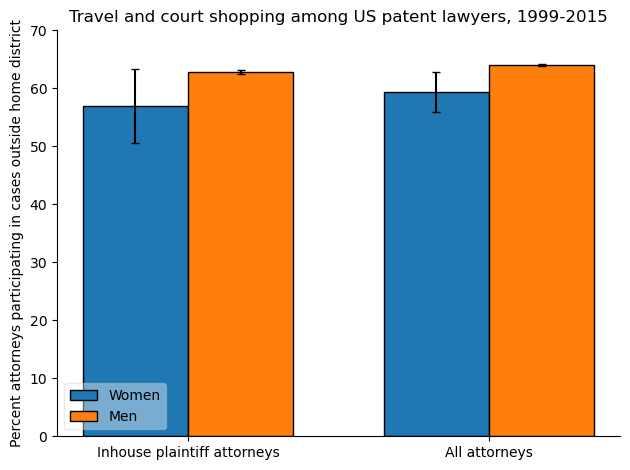

In [590]:
labels = ["Women", "Men"]

Row_list =[[100*inhouse_means[0], 100*inhouse_means[1]], [100*travel_means[1], 100*travel_means[2]]]

c = [[196*inhouse_sem[0], 196*inhouse_sem[1]], [196*travel_sem[0], 196*travel_sem[1]]]

fig, ax = plt.subplots()

index = np.arange(2)
width = 0.35

rects1 = ax.bar(
    index, Row_list[0], width, label='Women', edgecolor="black", yerr=c[0], capsize=3
)

rects2 = ax.bar(
    index + width, Row_list[1], width, label='Men', edgecolor="black", yerr=c[1], capsize=3
)

ax.legend(framealpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((0, 70))

ax.set_ylabel('Percent attorneys participating in cases outside home district')
ax.set_title('Travel and court shopping among US patent lawyers, 1999-2015')

ax.set_xticks(index + 0.175)
ax.set_xticklabels(('Inhouse plaintiff attorneys', 'All attorneys'))

fig.tight_layout()

## 2.2 Maps and Interpretation

### Locations of female patent attorneys

In [655]:
df_att = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv")

df_att_uniq = df_att.merge(zip_district, how="left", left_on="zip", right_on="ZCTA5CE10")

# create a dataset with one row for each unique attorney
df_att_uniq = df_att_uniq.groupby(["name_attorney","zip"]).agg({'female': "first", "male": "first", "NAME": "first",
     'Population': "first"})

df_att_uniq = df_att_uniq.reset_index()

C:\Users\schwa\AppData\Local\Temp\ipykernel_22592\1861115357.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_att = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv")


In [673]:
# group by district
fem_map = df_att_uniq.groupby("NAME").agg({'female': "sum", "male": "sum",
     'Population': "first"})

# merge with file displaying polygons for districts
fem_map = district_df.merge(fem_map, on="NAME", how="left")
fem_map.set_geometry("geometry", inplace=True)

fem_map["per_f"] = 100* fem_map["female"] / (fem_map["female"] + fem_map["male"])

# create variable displaying attorneys per 100,000
fem_map["f_att_per_100000"] = 100000* fem_map["female"] / fem_map["Population_x"]
# fem_map["f_att_per_100000"] = math.log(fem_map["f_att_per_100000"].astype(float))
# fem_map.sort_values("f_att_per_100000", ascending=False)

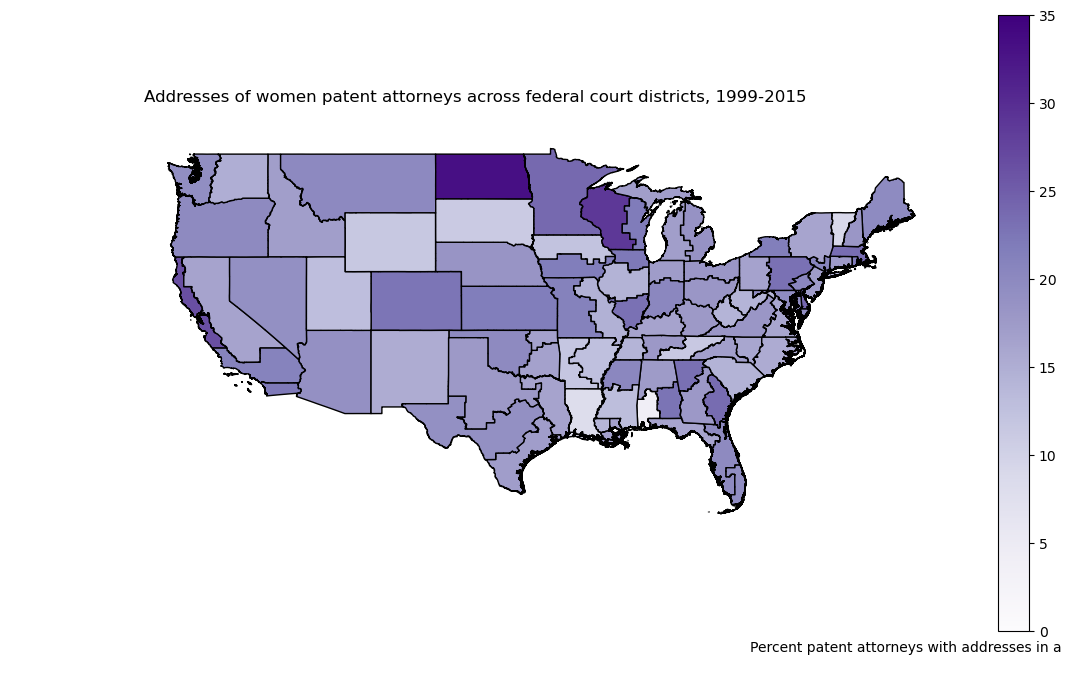

In [671]:
fig, gax = plt.subplots(figsize=(15,8))

viridis= mpl.colormaps["viridis"].resampled(256)

newcmp = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])

fem_map.plot(ax=gax, edgecolor="black", column="per_f", legend=True, vmin=0, vmax=35, cmap="Purples")

# Add text to let people know what we are plotting
gax.annotate('Percent patent attorneys with addresses in a district who are women',xy=(0.5, 0.05),  xycoords='figure fraction')

# gax.annotate('+',xy=(.7, 0.82),  xycoords='figure fraction')

gax.set_xlim(-137, -65)
gax.set_ylim(23, 52) 

gax.set_title("Addresses of women patent attorneys across federal court districts, 1999-2015")

plt.axis('off')

plt.show()

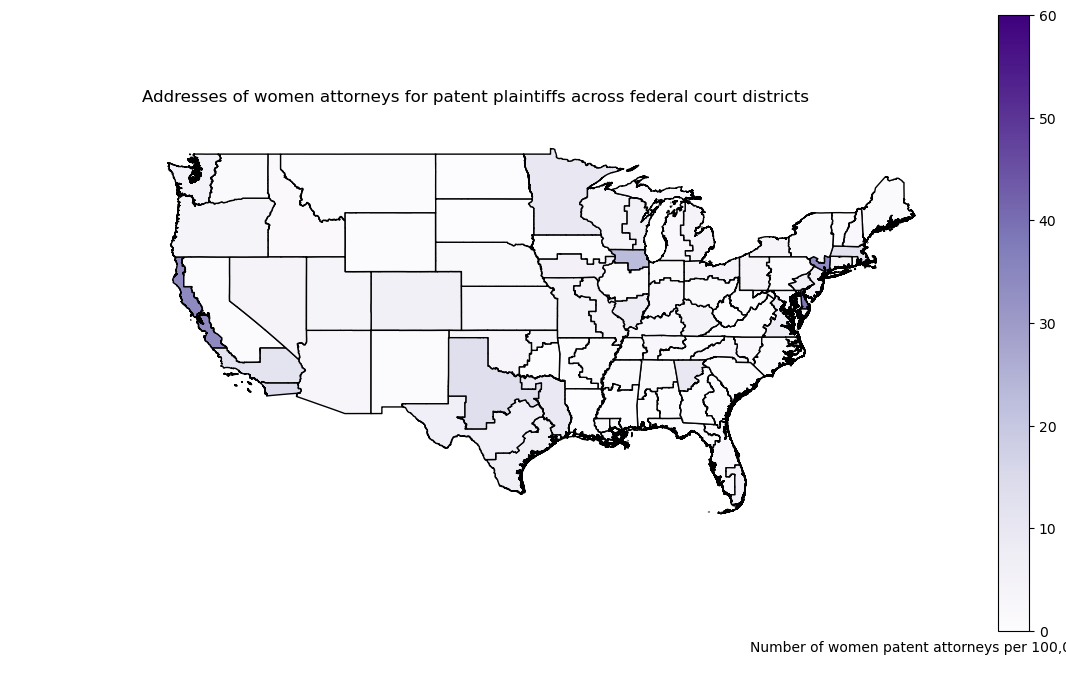

In [675]:
fig, gax = plt.subplots(figsize=(15,8))

fem_map.plot(ax=gax, edgecolor="black", column="f_att_per_100000", legend=True, vmin=0, vmax=60, cmap="Purples")

# Add text to let people know what we are plotting
gax.annotate('Number of women patent attorneys per 100,000 people',xy=(0.5, 0.05),  xycoords='figure fraction')

# gax.annotate('+',xy=(.7, 0.82),  xycoords='figure fraction')

gax.set_xlim(-137, -65)
gax.set_ylim(23, 52) 

gax.set_title("Addresses of women attorneys for patent plaintiffs across federal court districts")

plt.axis('off')

plt.show()

### Court Shopping Among Inhouse Attorneys

In [ ]:
# aggregate across district
df_p_map = df_p[["NAME", "plaintiff", "male", "female", "court_shopping", "court_shop_M", "court_shop_F"]]
df_p_map = df_p_map.groupby("NAME").agg("sum")
df_p_map = df_p_map.reset_index()

# merge w district data
df_p_map = district_df.merge(df_p_map, on="NAME", how="left")

df_p_map.set_geometry("geometry", inplace=True)

In [ ]:
df_p_map["prop_court_shop"] = 100 * df_p_map["court_shopping"] / df_p_map["plaintiff"]
df_p_map = df_p_map.fillna(0)

df_p_map.sort_values("prop_court_shop", ascending=True).head()

In [ ]:
fig, gax = plt.subplots(figsize=(15,8))

df_p_map.plot(ax=gax, edgecolor="black", column="prop_court_shop", legend=True, vmin=0, vmax=100, cmap="Purples")
# zip_df_merge.plot(
   # ax=gax, edgecolor="none", column='female', legend=True, vmin=0, vmax=30, cmap="RdPu" #range of your column value for the color legend
# )

# Add text to let people know what we are plotting
gax.annotate("Percent of cases filed by plaintiff attorneys outside jurisdiction",xy=(0.4, 0.05),  xycoords='figure fraction')

# gax.annotate('+',xy=(.7, 0.82),  xycoords='figure fraction')

gax.set_xlim(-137, -65)
gax.set_ylim(23, 52) 

gax.set_title("Court shopping by inhouse patent attorneys across federal court districts")

plt.axis('off')

plt.show()

### Attorneys participating in cases requiring travel

In [ ]:
# aggregate across district
df_a_map = df_full[["NAME", "male", "female", "travel", "travel_M", "travel_F", "total"]]
df_a_map = df_a_map.groupby("NAME").agg("sum")
df_a_map = df_a_map.reset_index()

df_a_map["prop_travel_F"] = 100 * df_a_map["travel_F"] / df_a_map["female"]
df_a_map["prop_travel_M"] = 100 * df_a_map["travel_M"] / df_a_map["male"]

# merge w district data
df_a_map = district_df.merge(df_a_map, on="NAME", how="left")
df_a_map = df_a_map.fillna(0)

df_a_map.set_geometry("geometry", inplace=True)

In [ ]:
df_a_map.sort_values("prop_travel_F", ascending=False)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), gridspec_kw={'width_ratios': [1, 1.25]})

ax1 = df_a_map.plot(ax=ax1, edgecolor="black", column="prop_travel_F", legend=False, vmin=0, vmax=100, cmap="Purples")
ax2 = df_a_map.plot(ax=ax2, edgecolor="black", column="prop_travel_M", legend=True, vmin=0, vmax=100, cmap="Purples")
# zip_df_merge.plot(
   # ax=gax, edgecolor="none", column='female', legend=True, vmin=0, vmax=30, cmap="RdPu" #range of your column value for the color legend
# )

# Add text to let people know what we are plotting
# ax1.annotate("Percent attorneys involved in cases outside their home district ",xy=(0.05, 0.05),  xycoords='figure fraction')
ax2.annotate("Percent attorneys involved in cases outside their home district ",xy=(0.44, 0.05),  xycoords='figure fraction')

# gax.annotate('+',xy=(.7, 0.82),  xycoords='figure fraction')

ax1.set_xlim(-137, -65)
ax1.set_ylim(23, 52) 

ax2.set_xlim(-137, -65)
ax2.set_ylim(23, 52) 

fig.suptitle("Travel by patent attorneys across federal court districts, 1999-2015", fontsize=16)

plt.axis('off')
ax1.axis('off')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax1.set_title("Female attorneys")
ax2.set_title("Male attorneys")

plt.show()

## 2.3 Regressions

### Regression on attorney travel

In [562]:
# create dummy variable for year ranges
df_full["years_99_05"] = np.where(df_full['year_filed'] <= 2005.3, 1, 0)
df_full["years_06_10"] = np.where((df_full['year_filed'] <= 2010.3) & (df_full['year_filed'] > 2005.3), 1, 0)
df_full["years_11_15"] = np.where(df_full['year_filed'] > 2010.3, 1, 0)

In [564]:
# regress court shopping on gender, whether person is plaintiff or defendant, year range, number of attorneys

# create subset of the dataset that drops nas
df = df_full.dropna(subset=["travel"])

# insert column for constant
df['const'] = 1

# interaction between plaintiff and number of plaintiff attorneys
# df["plainxtot_plain"] = df["plaintiff"] * df["tot_plain"]

# create variable lists
X1 = ['const', 'female']
X2 = ['const', 'female', 'plaintiff']
X3 = ['const', 'female', 'plaintiff', "plaintiff_F"]
X4 = ['const', 'female', 'plaintiff', "plaintiff_F", "years_06_10", "years_11_15"] 
X5 = ['const', 'female', 'plaintiff', "plaintiff_F", "years_06_10", "years_11_15", "tot"] 

reg1 = sm.OLS(df["travel"], df[X1], missing='drop').fit()
reg2 = sm.OLS(df["travel"], df[X2], missing='drop').fit()
reg3 = sm.OLS(df["travel"], df[X3], missing='drop').fit()
reg4 = sm.OLS(df["travel"], df[X4], missing='drop').fit()
reg5 = sm.OLS(df["travel"], df[X5], missing='drop').fit()

stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5])

HTML(stargazer.render_html())

### Regressions on inhouse attorney court shopping

In [566]:
# create dummy variable for year ranges
df_p["years_99_05"] = np.where(df_p['year_filed'] <= 2005.3, 1, 0)
df_p["years_06_10"] = np.where((df_p['year_filed'] <= 2010.3) & (df_p['year_filed'] > 2005.3), 1, 0)
df_p["years_11_15"] = np.where(df_p['year_filed'] > 2010.3, 1, 0)

In [568]:
# run regression on dataset that only includes plaintiff attorneys

# insert column for constant
df_p['const'] = 1

# create variable lists
X1 = ['const', 'female']
X2 = ['const', 'female', "years_06_10", "years_11_15"] 
X3 = ['const', 'female', "years_06_10", "years_11_15", "tot"] 
X4 = ['const', 'female', "years_06_10", "years_11_15", "tot", "tot_plain_F"]

reg1 = sm.OLS(df_p["court_shopping"], df_p[X1], missing='drop').fit()
reg2 = sm.OLS(df_p["court_shopping"], df_p[X2], missing='drop').fit()
reg3 = sm.OLS(df_p["court_shopping"], df_p[X3], missing='drop').fit()
reg4 = sm.OLS(df_p["court_shopping"], df_p[X4], missing='drop').fit()

stargazer = Stargazer([reg1, reg2, reg3, reg4])

HTML(stargazer.render_html())

## 2.4 Conclusion

### Bibliography

Alan C. Marco, Marco, A. C., Asrat Tesfayesus, Tesfayesus, A., Andrew A. Toole, Toole, A. A., & Andrew A. Toole. (2017). Patent Litigation Data from US District Court Electronic Records (1963-2015). https://doi.org/10.2139/ssrn.2942295

Atkinson, S. E., Marco, A. C., & Turner, J. L. (2009). The Economics of a Centralized Judiciary: Uniformity, Forum Shopping, and the Federal Circuit. The Journal of Law & Economics, 52(3), 411–443. https://doi.org/10.1086/597561

Jeong, Y.-J., Zvonkovic, A. M., Sano, Y., & Acock, A. C. (2013). The occurrence and frequency of overnight job travel in the USA. Work, Employment and Society, 27(1), 138–152. https://doi.org/10.1177/0950017012460328

Raffo, J. (2023). WGND 2.0 (Version 1.1) [Dataset]. Harvard Dataverse. https://doi.org/10.7910/DVN/MSEGSJ

Tu, S., Gugliuzza, P., & Semet, A. (2022). Overqualified and Underrepresented: Gender Inequality in Pharmaceutical Patent Law. BYU Law Review, 48(1), 137–196.

Yan Leychkis, & Leychkis, Y. (2007). Of Fire Ants and Claim Construction: An Empirical Study of the Meteoric Rise of the Eastern District of Texas as a Preeminent Forum for Patent Litigation. Yale Journal of Law and Technology, 9(1), 6.